In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

import pymc3 as pm
import arviz as az
from sklearn.preprocessing import scale

In [25]:
df = pd.read_csv('./dataJar/WIMADISO.txt',  delim_whitespace=True,
                 names=['day','month', 'year', 'temp'],
                 parse_dates=[['day', 'month', 'year']], na_values=-99)
df.rename(columns={'day_month_year': 'date'}, inplace=True)

In [26]:
df.head()

,date,temp
0,1995-01-01,19.6
1,1995-01-02,12.6
2,1995-01-03,13.0
3,1995-01-04,2.3
4,1995-01-05,4.7


In [31]:
df['temp_s'] = scale(df.temp)

In [32]:
df.describe()

,temp,temp_s
count,8665.000000,8.665000e+03
mean,47.949729,9.676173e-17
std,20.453172,1.000058e+00
min,-20.000000,-3.322402e+00
25%,32.300000,-7.651934e-01
50%,49.800000,9.046900e-02
75%,65.800000,8.727889e-01
max,90.600000,2.085385e+00


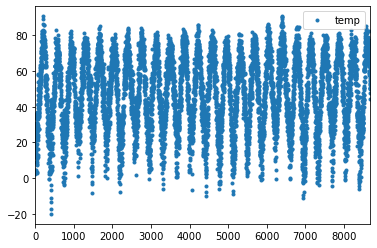

In [29]:
_, axs = pl.subplots(ncols=2, figsize=(12, 5))
df.plot(y=['temp', 'temp_s'], marker='.', ls='', ax=ax)

In [44]:
df.iloc[:8400].tail()

,date,temp,temp_s
8395,2017-12-26,-1.7,-2.427623
8396,2017-12-27,-2.9,-2.486297
8397,2017-12-28,1.7,-2.261380
8398,2017-12-29,9.6,-1.875110
8399,2017-12-30,2.6,-2.217375


In [33]:
X = df.iloc[8401].index.values

In [49]:
df.loc[df.date.dt.month]

,date,temp,temp_s


In [55]:
last_index = df.loc[((df.date.dt.month==12) & (df.date.dt.day==31))].index.values[-1]

In [64]:
ys.size

8402

In [66]:
X = df.loc[:last_index].index.values
ys = df.loc[:last_index, 'temp_s'].values

In [69]:
X[-1], ys.size, X.size

(8400, 8401, 8401)

In [77]:
daysperyear = 365.24219
wl = daysperyear / 2
ampPriorMax = 2
with pm.Model() as m1:
    ρ = pm.Normal('ρ', 0, 1)
    β0 = pm.Normal('β0', 0, 1)
    β1 = pm.Normal('β1', 0, 1)
    ar1 = pm.AR('ar1', ρ, sigma=1.0, shape=1, constant=False,
                init=pm.Normal.dist(mu=0, sd=1))
    amp = pm.Uniform('amp', 0, 2)
    phase = pm.Uniform('phase', -183, 183)
    ν = pm.Exponential('ν', 1/30)
    σ = pm.Exponential('σ', 1)
    trend_i = β0 + β1 * X + amp * pm.math.cos((X-phase) / wl)
    μ_i = trend_i + ar1 + ϵ
    y_i = pm.StudentT('y_i', mu=μ_i, sigma=σ, nu=ν, observed=ys)

In [78]:
with m1:
    trace = pm.sample(tune=2000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, ν, phase, amp, ar1, ϵ, β1, β0, ρ]
  0%|          | 0/2500 [00:00<?, ?it/s]


SamplingError: Bad initial energy